# Download Dataset

In [ ]:
!gdown --id 10fKUF1u3uhIrhEipoklNgysmPyYuYGV9 -O kaggle_m3.zip
!gdown --id 1Leaos-3uB70Lex1qLE7FvrtaOBDOYKbQ -O data_aug.zip

In [ ]:
! mkdir fakes
! cp data_aug.zip fakes
%cd fakes
! ls

In [ ]:
! unzip data_aug.zip

In [4]:
%cd ..

/content


In [ ]:
!unzip kaggle_m3.zip

# Import Dataset

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import pandas as pd
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
import tensorflow as tf
from skimage.color import rgb2gray

import os
import cv2
from PIL import Image
import numpy as np

In [7]:
# Set parameters
file_path='/'
Size = (256, 256)
mask_files = glob(file_path + os.path.join('content','*','*_mask*'))
train_files = [file.replace('_mask', '') for file in mask_files]

# Create Dataframe
def label(mask):
    value = np.max(cv2.imread(mask))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image": train_files,
                   "mask": mask_files,
                  "label":[label(x) for x in mask_files]})


df.shape

(5302, 3)

In [8]:
# Collect Data
dataset = [ rgb2gray(cv2.imread(path)) for path in df["image"]  ]
label = df["label"].values
dataset = np.array(dataset)
label = np.array(df["label"].values).astype(int)
print(dataset.shape)
print(label.shape)

(5302, 256, 256)
(5302,)


In [ ]:
# dataset_gray = dataset[:, :, :, np.newaxis]



# Split Data

In [9]:
from sklearn.model_selection import train_test_split
#from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(dataset, label, test_size = 0.1, random_state = 0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, random_state = 0)

In [12]:
print(X_train.shape)
print(X_test.shape)

(4771, 256, 256)
(265, 256, 256)


# PCA - PC-reconstructed image using less features (90%)

In [11]:
from sklearn  import decomposition 
pca_model = decomposition.PCA(0.9) #if you dont specify n_componenets it will be min(n_sample,n_features)

In [15]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

In [16]:
print(X_train_flat.shape)
print(X_test_flat.shape)
print(X_test_flat.shape)

(4771, 65536)
(265, 65536)
(265, 65536)


In [17]:
pca_model.fit(X_train_flat)
pca_projection_train = pca_model.transform(X_train_flat) #this is scores

In [18]:
pca_projection_test = pca_model.transform(X_test_flat) #this is scores
pca_projection_val = pca_model.transform(X_val_flat) #this is scores

In [25]:
print(pca_projection_train.shape)
print(pca_projection_test.shape)
print(pca_projection_val.shape)

(4771, 457)
(265, 457)
(266, 457)


## Image for eigenvector



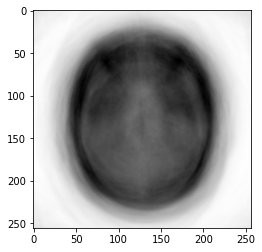

In [20]:
eigenvectors = pca_model.components_  
pc1= eigenvectors[0,:].reshape(256,256)
plt.imshow(pc1,cmap='gray_r') 

In [26]:
pca_recovered_train = pca_model.inverse_transform(pca_projection_train)
pca_recovered_test = pca_model.inverse_transform(pca_projection_test)
pca_recovered_val = pca_model.inverse_transform(pca_projection_val)

print(pca_recovered_train.shape)
print(pca_recovered_test.shape)
print(pca_recovered_val.shape)

(4771, 65536)
(265, 65536)
(266, 65536)


In [27]:
pca_recovered_train_image = pca_recovered_train.reshape(pca_recovered_train.shape[0], 256, 256)
pca_recovered_test_image = pca_recovered_test.reshape(pca_recovered_test.shape[0], 256, 256)
pca_recovered_val_image = pca_recovered_val.reshape(pca_recovered_val.shape[0], 256, 256)

print(pca_recovered_train_image.shape)
print(pca_recovered_test_image.shape)
print(pca_recovered_val_image.shape)

(4771, 256, 256)
(265, 256, 256)
(266, 256, 256)


In [28]:
pca_recovered_train_image = pca_recovered_train_image[:, :, :, np.newaxis]
pca_recovered_test_image = pca_recovered_test_image[:, :, :, np.newaxis]
pca_recovered_val_image = pca_recovered_val_image[:, :, :, np.newaxis]

print(pca_recovered_train_image.shape)
print(pca_recovered_test_image.shape)
print(pca_recovered_val_image.shape)

(4771, 256, 256, 1)
(265, 256, 256, 1)
(266, 256, 256, 1)


# CNN

In [29]:
metrics = ['binary_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]

GRAY_INPUT_SHAPE = (256, 256, 1)
COLOR_INPUT_SHAPE = (256, 256, 3)

def model_builder(optimizer):
    INPUT_SHAPE = GRAY_INPUT_SHAPE   #change to (SIZE, SIZE, 3)


    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), kernel_initializer = 'he_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), kernel_initializer = 'he_uniform', padding="same"))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(128))
    model.add(Activation('relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid')) 

    model.compile(
        optimizer=optimizer, 
        loss="binary_crossentropy", 
        metrics=metrics,
    )

    return model

## EarlyStopping

In [30]:
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15, restore_best_weights=True)

## Hyper Params

In [31]:
epochs = 1000
learning_rate = 0.0005
batch_size = 128

## Helper Functions

In [32]:
def set_seed(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(888)

In [33]:
def plot_loss_and_acurracy(history):
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
  epochs = range(len(history.history['loss']))

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  axes[0].plot(epochs, loss, 'y', label='Training loss')
  axes[0].plot(epochs, val_loss, 'r', label='Validation loss')
  axes[0].set_title('Training and validation loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].legend()

  acc = history.history['binary_accuracy']
  val_acc = history.history['val_binary_accuracy']
  axes[1].plot(epochs, acc, 'y', label='Training acc')
  axes[1].plot(epochs, val_acc, 'r', label='Validation acc')
  axes[1].set_title('Training and validation accuracy')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')
  axes[1].legend()

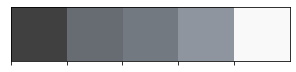

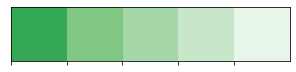

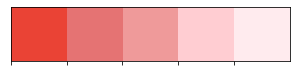

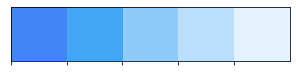

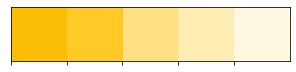

In [34]:
colors_dark = ["#404040", "#676c72", '#737980', '#8e959e', '#f9f9f9']
colors_red = ["#EA4335", "#E57373", '#EF9A9A', '#FFCDD2', '#FFEBEE']
colors_green = ['#34A853','#81C784','#A5D6A7','#C8E6C9','#E8F5E9']
colors_blue = ['#4285F4','#42A5F5','#90CAF9','#BBDEFB','#E3F2FD']
colors_yellow = ['#FBBC04','#FFCA28','#FFE082','#FFECB3','#FFF8E1']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)
sns.palplot(colors_blue)
sns.palplot(colors_yellow)

In [35]:
def plot_history_precision_recall(history):
    epochs = range(len(history.history['loss']))
    fig, ax = plt.subplots(1,2,figsize=(14,7))
    train_acc = history.history['precision']
    train_loss = history.history['recall']
    val_acc = history.history['val_precision']
    val_loss = history.history['val_recall']

    fig.text(s='Epochs vs. Training and Validation Precision/Recall',size=18,fontweight='bold',
                 fontname='monospace',color=colors_dark[0],y=1,x=0.28,alpha=0.8)

    sns.despine()
    ax[0].plot(epochs, train_acc, color=colors_green[1],
               label = 'Training Precision')
    ax[0].plot(epochs, val_acc, color=colors_yellow[1],
               label = 'Validation Precision')
    ax[0].legend(frameon=False)
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Training & Validation Precision')

    sns.despine()
    ax[1].plot(epochs, train_loss, color=colors_green[1],
               label ='Training Recall')
    ax[1].plot(epochs, val_loss, color=colors_yellow[1],
               label = 'Validation Recall')
    ax[1].legend(frameon=False)
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Training & Validation Recall')

    fig.show()

In [36]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from numpy.random import randint

import matplotlib.colors as colors
colors_list = list(colors._colors_full_map.values())


def plot_roc_curve(models):
  auc_list = []

  plt.figure(figsize=(12, 8))
  plt.plot([0, 1], [0, 1], 'y--')
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')

  for idx, (name, model) in enumerate(models):
    y_preds = model.predict(X_test).ravel()
    fpr, tpr, thresholds = roc_curve(y_test, y_preds) 
    auc_value = auc(fpr, tpr)
    auc_list.append(auc_value)
    label = str(name) + " - AUC: " + str(round(auc_value, 3))
    plt.plot(fpr, tpr, marker='.', color=colors_list[randint(len(colors_list) - 1)], label=label)

  plt.legend()
  
  return auc_list


## Optimizer - Adam

In [37]:
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True)
model_adam = model_builder(opt)

history_adam = model_adam.fit(pca_recovered_train_image, 
                         y_train, 
                         batch_size = batch_size, 
                         verbose = 1, 
                         epochs = epochs,      
                         validation_data=(pca_recovered_val_image,y_val), # I will use X_val as hold out dataset
                         shuffle = True,
                         callbacks=[es]
                     )

Epoch 1/1000
38/38 [==============================] - 27s 303ms/step - loss: 1.8440 - binary_accuracy: 0.6841 - precision: 0.6919 - recall: 0.7061 - val_loss: 0.8930 - val_binary_accuracy: 0.4925 - val_precision: 0.4925 - val_recall: 1.0000
Epoch 2/1000
38/38 [==============================] - 9s 243ms/step - loss: 0.4937 - binary_accuracy: 0.7743 - precision: 0.7596 - recall: 0.8268 - val_loss: 3.5560 - val_binary_accuracy: 0.4925 - val_precision: 0.4925 - val_recall: 1.0000
Epoch 3/1000
38/38 [==============================] - 9s 243ms/step - loss: 0.4160 - binary_accuracy: 0.8000 - precision: 0.7652 - recall: 0.8870 - val_loss: 5.8425 - val_binary_accuracy: 0.4925 - val_precision: 0.4925 - val_recall: 1.0000
Epoch 4/1000
38/38 [==============================] - 9s 246ms/step - loss: 0.3679 - binary_accuracy: 0.8128 - precision: 0.7628 - recall: 0.9281 - val_loss: 5.9714 - val_binary_accuracy: 0.4925 - val_precision: 0.4925 - val_recall: 1.0000
Epoch 5/1000
38/38 [===================

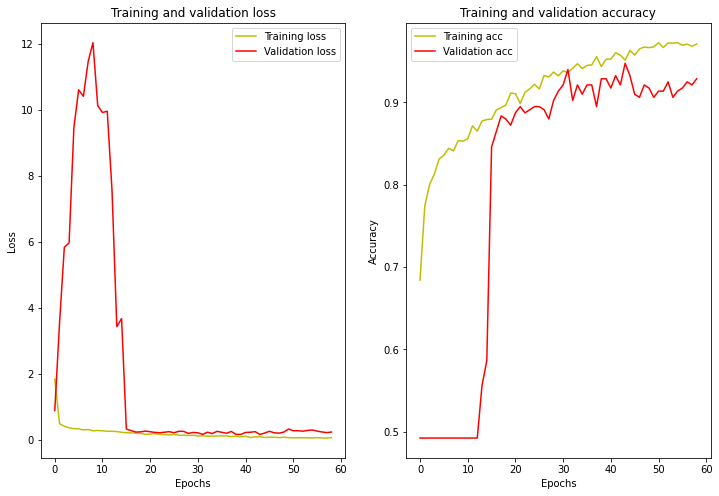

In [38]:
plot_loss_and_acurracy(history_adam)

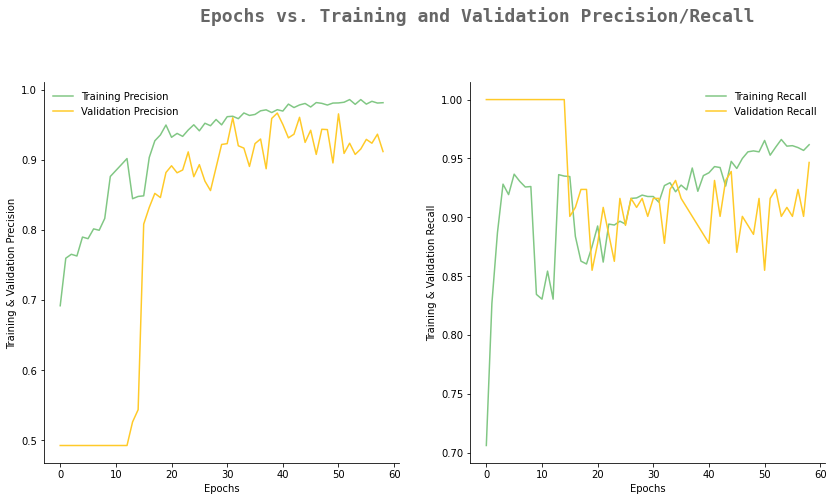

In [39]:
plot_history_precision_recall(history_adam)

In [40]:
model_adam.evaluate(pca_recovered_test_image,y_test) # use X_val as hold out dataset

9/9 [==============================] - 1s 38ms/step - loss: 0.3539 - binary_accuracy: 0.9094 - precision: 0.9071 - recall: 0.9203


[0.35390007495880127,
 0.9094339609146118,
 0.9071428775787354,
 0.9202898740768433]

[0.9292479744379778]

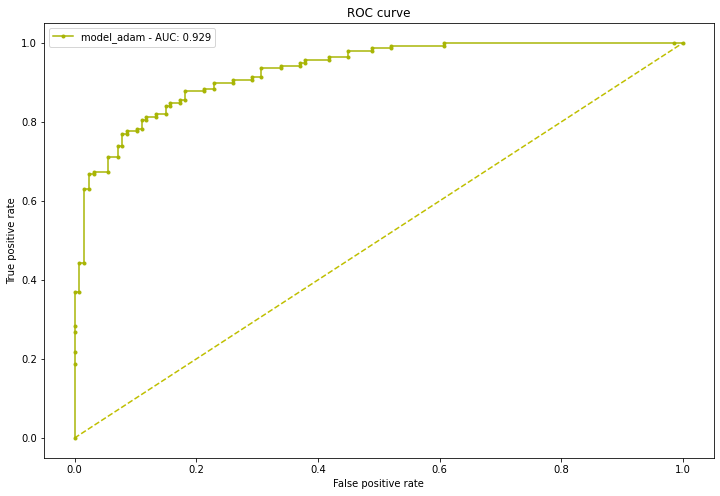

In [41]:
models = [("model_adam", model_adam)]

plot_roc_curve(models)

# Save model to my drive

In [42]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [46]:
model_adam.save('new_cnn_model_full_dataset_gray_image_pca.h5')